In [1]:
import os
import shutil

import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

from tqdm import tqdm

In [2]:
def f(x,w,b):
    return x @ w + b.view(1)

In [3]:
def MSE(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

In [4]:
def reglin(x_train, y_train, x_test, y_test, batch_size=32, eps=1e-3, n_iter=100):
    
    n, d = x_train.shape
    
    w = torch.rand(d, requires_grad=True)
    b = torch.rand(1, requires_grad=True)
    
    # Récupére l'emplacement du fichier
    script_dir = os.getcwd() 
    runs_dir = os.path.join(script_dir, "runs")
    
    # Vérifie si le dossier "runs" existe
    if os.path.exists(runs_dir):
        # Supprime le dossier "runs" et tout son contenu
        shutil.rmtree(runs_dir)
        
    # Recrée le dossier "runs"
    os.makedirs(runs_dir, exist_ok=True)
    
    # Définit le SummaryWriter
    logger = SummaryWriter(os.path.join(script_dir, "runs"))
    
    for epoch in tqdm(range(n_iter)):
        
        cumloss = 0
        for batch in range(n // batch_size):
            
            index = torch.randint(0, n, size=(batch_size,))
            x_batch = x_train[index]
            y_pred = f(x_batch, w, b)
            loss = MSE(y_pred, y_train[index])
            cumloss += loss
            
            # backpropagation
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_([w, b], max_norm=1.0)
            
            with torch.no_grad():
                w -= eps * w.grad
                b -= eps * b.grad
            
            w.grad.zero_()
            b.grad.zero_()
        
        cumloss = cumloss.detach().numpy() / (n // batch_size)
        logger.add_scalar("train_loss", cumloss, epoch)
        
        with torch.no_grad():
            loss = MSE(f(x_test, w, b), y_test).item()
            logger.add_scalar("test_loss", loss, epoch)
            
            

In [5]:
X = california_housing.data
y = california_housing.target

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

scaler = StandardScaler()
scaler.fit_transform(X_tensor,y_tensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=0)

In [6]:
torch.manual_seed(0)

reglin(X_train, y_train, X_test, y_test)

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


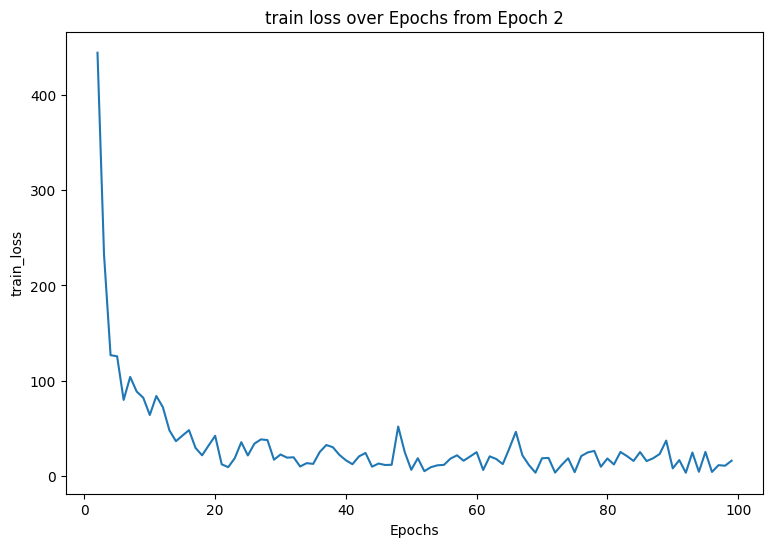

In [7]:
script_dir = os.getcwd() 
runs_dir = os.path.join(script_dir, "runs")

ea = event_accumulator.EventAccumulator(runs_dir)
ea.Reload()

# Récupére les valeurs de train_loss
values1 = ea.Scalars("train_loss")

# Extraire les itérations et les valeurs de f(beta)
epochs = [entry.step for entry in values1]
train_loss = [entry.value for entry in values1]

# plot
plt.figure(figsize=(9, 6))
plt.plot(epochs[2:], train_loss[2:])
plt.xlabel('Epochs')
plt.ylabel('train_loss')
plt.title('train loss over Epochs from Epoch 2')
plt.show()

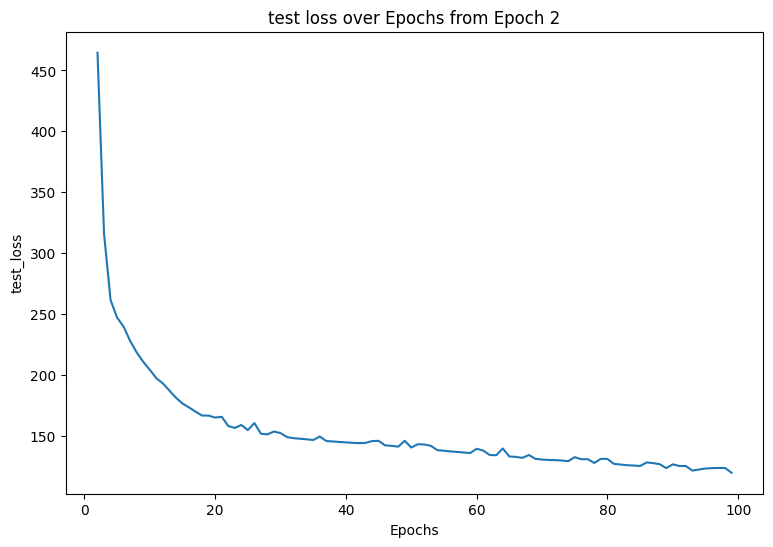

In [12]:
values2 = ea.Scalars("test_loss")

epochs = [entry.step for entry in values2]
test_loss = [entry.value for entry in values2]

plt.figure(figsize=(9, 6))
plt.plot(epochs[2:], test_loss[2:])
plt.xlabel('Epochs')
plt.ylabel('test_loss')
plt.title('test loss over Epochs from Epoch 2')
plt.show()

In [13]:
print(train_loss[:5])

[51080.76953125, 968.919189453125, 444.0953674316406, 232.1557159423828, 126.77093505859375]


Les premières valeurs de la loss sont très grandes donc on doit clipper pour que le gradient d'explose pas